# Multimodal Image and Text Classification Project

## Overview

This project aims to develop a deep learning model that classifies various types of garbage into predefined categories using a combination of image and text data. The architecture combines a Convolutional Neural Network (CNN) for image feature extraction and a DistilBERT model for text feature extraction.

The project uses PyTorch as the deep learning framework, `transformers` for text processing, and is designed to run efficiently on a GPU cluster using Slurm.

## Project Structure
Data can be stored in the following directory or under `/work/TALC/enel645_2024f/garbage_data`

```
├── data/                            # Dataset folder
│   ├── CVPR_2024_dataset_Train      # Training images
│   ├── CVPR_2024_dataset_Val        # Validation images
│   ├── CVPR_2024_dataset_Test       # Test images
├── setup_conda_environment.sh       # Script to set up the conda environment
├── train_eval_model_notebook.py                   # Jupyter notebook for training and evaluating the model
├── train_model.py                   # Python script for training the model (same code as the notebook)
├── README.md                        # This README file
├── slurm_submit_job.sh              # Slurm submission script
└── train_image_descriptions.csv     # CSV file containing captions for training images
```

## Setup Instructions

### Prerequisites

- [Anaconda/Miniconda](https://docs.conda.io/projects/conda/en/latest/user-guide/install/index.html) installed.
- Access to a GPU-enabled server or cluster.

### Step 1: Set up Conda Environment

1. **Create and activate the conda environment** using the provided script:

   ```bash
   ./setup_conda_environment.sh
   ```

   This script checks for an existing conda environment named `mm_enel645_assg2`, creates it if it does not exist, and installs all necessary packages.

2. **Verify the installation**:

   ```bash
   conda activate mm_enel645_assg2
   conda list
   ```

### Step 2: Train the Model

1. **Submit the training job to the cluster** using the provided Slurm script:

   ```bash
   sbatch slurm_submit_job.sh
   ```

   This Slurm script (`slurm_submit_job.sh`) allocates the necessary resources (nodes, CPUs, GPUs, memory, etc.) and runs the `train_model.py` script to start training the model.

2. **Monitor the job**:

   You can monitor the Slurm job with:

   ```bash
   squeue -u your_username
   ```

   You can also check the output and error logs using the `.out` and `.err` files generated by Slurm.

### Step 3: Model Evaluation

After training completes, the model will be evaluated on the test set. The results are displayed in a confusion matrix, along with other performance metrics like accuracy, precision, and recall.

## Files Description

- **`setup_conda_environment.sh`**: Bash script to set up the conda environment and install all dependencies.
- **`train_model.py`**: Python script containing all necessary code to train the multimodal model.
- **`slurm_submit_job.sh`**: Slurm batch script for submitting the training job to a cluster.
- **`train_image_descriptions.csv`**: CSV file that contains descriptions/captions for the training images.
- **`README.md`**: This documentation file.

## Requirements

- `torch`: For deep learning model creation.
- `torchvision`: For image data processing.
- `transformers`: For text data processing with DistilBERT.
- `scikit-learn`: For evaluation metrics.
- `matplotlib` and `seaborn`: For plotting confusion matrix and other visualizations.
- `pillow` and `numpy`: For image and numerical data handling.

## Example Usage

1. **Run the training script locally**:

   ```bash
   python train_model.py
   ```

2. **Submit the job to a cluster**:

   ```bash
   sbatch slurm_submit_job.sh
   ```

3. **Check the output** in the Slurm `.out` file to monitor the progress and performance metrics.

## Data and Methods

This project uses a combination of image data and text descriptions to classify images into four categories: Black, Blue, Green, and TTR. The model architecture consists of a ResNet50 model for image feature extraction and a DistilBERT model for processing text descriptions.

### Dataset

- **Image Data**: RGB images of varying resolutions.
- **Text Data**: Generated captions associated with each image.

### Methodology

1. **Data Preprocessing**: Resizing images, tokenizing text, and applying necessary augmentations.
2. **Model**: A multimodal neural network with ResNet50 and DistilBERT components.
3. **Training**: Uses a weighted cross-entropy loss function to account for class imbalance.
4. **Evaluation**: Performance metrics like accuracy, precision, recall, and confusion matrix are computed.

## Contact Information

For any questions or issues, please reach out to `muhammad.mahajna@ucalgary.ca`.

## License

This project is licensed under the MIT License - see the LICENSE file for details.


In [5]:
# Import needed libraries
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import models, transforms
from torchvision.models import ResNet50_Weights
from transformers import DistilBertModel, DistilBertTokenizer
from PIL import Image
import numpy as np
import pandas as pd
import re
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score
import matplotlib.pyplot as plt
import seaborn as sns
import string

# Define device (prefer CUDA>>MPS>>CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
print(f'Using device: {device}')

Using device: mps


Using base directory: ../../data/enel645_2024f/garbage_data
Black: 2111 samples, Weight: 0.2662
Blue: 4355 samples, Weight: 0.1291
Green: 1991 samples, Weight: 0.2823
TTR: 1743 samples, Weight: 0.3224


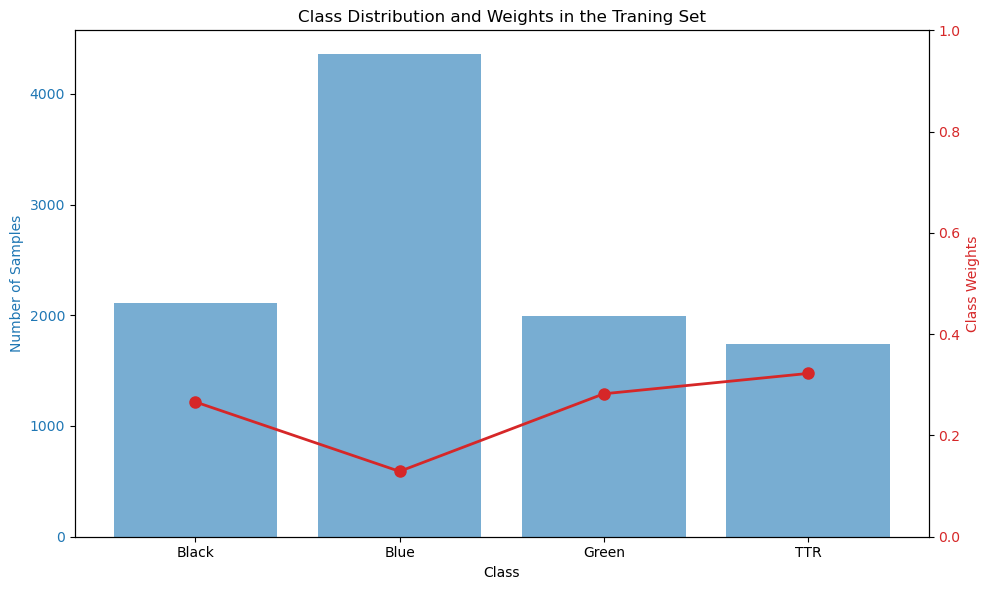

In [6]:
# Data preparation
# Label map
label_map = {"Black": 0, "Blue": 1, "Green": 2, "TTR": 3} # Labels are converted into integers


# Load data - given a data directory, load images, descriptions from text and label from folder
def load_data(data_dir, label_map):
    image_paths = []
    texts = []
    labels = []

    for label_name, label_idx in label_map.items(): # load for each label/folder
        folder_path = os.path.join(data_dir, label_name)
        if not os.path.isdir(folder_path):
            continue

        # Iterate through all files in the folder
        for filename in os.listdir(folder_path):
            # Take only image files
            if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
                image_path = os.path.join(folder_path, filename)
                image_paths.append(image_path)

                # Use the filename as the text description, remove trailing numbers
                file_name_no_ext, _ = os.path.splitext(filename)
                text_description = re.sub(r'\d+', '', file_name_no_ext.replace('_', ' '))
                texts.append(text_description)

                labels.append(label_idx)

    return np.array(image_paths), np.array(texts), np.array(labels)

# Function to detect the base directory depending on the PC (support for local pc and TALC cluster)
def detect_base_directory():
    possible_dirs = [
        r"/work/TALC/enel645_2024f/garbage_data",  # Directory on TALC cluster
        r"../../data/enel645_2024f/garbage_data"  # Directory on LAPTOP - relative
    ]

    for base_dir in possible_dirs:
        if os.path.exists(base_dir):
            print(f"Using base directory: {base_dir}")
            return base_dir

    raise ValueError("No valid base directory found.") # Could not locate data directory. Add your data directory to the possible_dirs array

# Base directory detection
base_dir = detect_base_directory()

# Define the train, val, and test directories
train_dir = os.path.join(base_dir, "CVPR_2024_dataset_Train")
val_dir = os.path.join(base_dir, "CVPR_2024_dataset_Val")
test_dir = os.path.join(base_dir, "CVPR_2024_dataset_Test")

# Load all data at once (train, validate, test)
train_image_paths, train_texts, train_labels = load_data(train_dir, label_map)
val_image_paths, val_texts, val_labels = load_data(val_dir, label_map)
test_image_paths, test_texts, test_labels = load_data(test_dir, label_map)

# Define the custom dataset that will hold our training, validation, and test data
class MultimodalDataset(Dataset):
    def __init__(self, image_paths, texts, labels, transform=None, tokenizer=None, max_len=24):
        self.image_paths = image_paths  # Image data
        self.texts = texts              # Text descriptions
        self.labels = labels            # Labels
        self.transform = transform      # Data augmentation and preprocessing transfor
        self.tokenizer = tokenizer      # Tokenizer for the description text
        self.max_len = max_len

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        
        # Load image and transform
        image = Image.open(self.image_paths[idx]).convert('RGB') # Make sure we are using RGB color space
        if self.transform:
            image = self.transform(image) # Apply the transfor to the iamge to standardize and normalize it

        # Tokenize text
        text = str(self.texts[idx])
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        label = self.labels[idx] # get the label of the current data element (iamge+text+label)

        # Return the data structure containing the image, text and label
        return {
            'image': image,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(label, dtype=torch.long)
        }


# Data augmentation and preprocessing
transform = transforms.Compose([
    transforms.Resize((224, 224)),      # Resize the image to 224x224
    transforms.RandomHorizontalFlip(),  # Add a random horizontal flip
    transforms.RandomVerticalFlip(),    # Add a random vertical flip
    transforms.RandomRotation(20),      # Add some rotation
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1), # Simulate some color jitter
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # Normalize thr iamge values, keep it RGB
])

# Initialize tokenizer
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased') # use DistilBert: https://huggingface.co/docs/transformers/en/model_doc/distilbert

# Create datasets 
train_dataset = MultimodalDataset(train_image_paths, train_texts, train_labels, transform=transform, tokenizer=tokenizer)
val_dataset = MultimodalDataset(val_image_paths, val_texts, val_labels, transform=transform, tokenizer=tokenizer)
test_dataset = MultimodalDataset(test_image_paths, test_texts, test_labels, transform=transform, tokenizer=tokenizer)

# Create Data loaders 
batch_size = 16 # Keep it small for local training. When running on cluster it can be increasd to 32 or 64 (based on available memory)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


# Now let's check that we actually have the data
# Count the number of files in each class directory inthe training direcotry
class_counts = np.zeros(len(label_map), dtype=np.int32)
for label_name, label_idx in label_map.items():
    folder_path = os.path.join(train_dir, label_name)
    if os.path.isdir(folder_path):
        class_counts[label_idx] = len([f for f in os.listdir(folder_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))])

# Calculate the class weights using inverse frequency
# Since the data is asymetric (different classes have differnet number of samples in the training set), we will use these weights during the optimization procedure
class_weights = 1.0 / class_counts
class_weights = class_weights / class_weights.sum()  # Normalize to sum to 1
class_weights = torch.tensor(class_weights, dtype=torch.float32).to(device)

# Print the class counts and weights
for class_name, count, weight in zip(label_map.keys(), class_counts, class_weights):
    print(f'{class_name}: {count} samples, Weight: {weight:.4f}')


# Data for visualization
class_names = list(label_map.keys())

# Plotting the class distribution and weights
fig, ax1 = plt.subplots(figsize=(10, 6))

# Bar plot for class counts
color = 'tab:blue'
ax1.set_xlabel('Class')
ax1.set_ylabel('Number of Samples', color=color)
ax1.bar(class_names, class_counts, color=color, alpha=0.6)
ax1.tick_params(axis='y', labelcolor=color)

# Create a second y-axis for the weights
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Class Weights', color=color)
ax2.plot(class_names, class_weights.cpu().numpy(), color=color, marker='o', linestyle='-', linewidth=2, markersize=8)
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylim(0,1)
# Add title
plt.title('Class Distribution and Weights in the Traning Set')

# Show plot
plt.tight_layout()
plt.show()


In [7]:

# Multimodal model combining ResNet50 and DistilBERT
class MultimodalModel(nn.Module):
    def __init__(self, num_classes):
        super(MultimodalModel, self).__init__()
        # Load pretrained ResNet50 model
        self.resnet = models.resnet50(weights=ResNet50_Weights.DEFAULT)
        self.resnet.fc = nn.Identity()
        self.resnet_feature_dim = 2048

        # Load DistilBERT model
        self.distilbert = DistilBertModel.from_pretrained('distilbert-base-uncased')
        self.distilbert_feature_dim = 768

        # Fully connected layers for combining features (3 layers)
        self.fc = nn.Sequential(
            nn.Linear(self.resnet_feature_dim + self.distilbert_feature_dim, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Dropout(0.3), # 30% dropout to reduce overfitting
            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, num_classes)
        )
            
    def forward(self, images, input_ids, attention_mask):
        # Extract image features
        image_features = self.resnet(images)
        # Extract text features
        text_features = self.distilbert(input_ids=input_ids, attention_mask=attention_mask).last_hidden_state[:, 0, :]

        # Concatenate image and text features
        combined_features = torch.cat((image_features, text_features), dim=1)

        # Pass through fully connected layers
        output = self.fc(combined_features)
        return output


# Hyperparameters and model setup
num_classes = len(label_map)
learning_rate = 2e-5

model = MultimodalModel(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.AdamW(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /Users/muhammadmahajna/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 167MB/s]


In [ ]:
# Training with early stopping
best_val_loss = float('inf')    # start with super high value (infinity)
patience = 5                    # How many epochs without improvement to allow
epochs_no_improve = 0           # Placeholder
num_epochs = 10                 # Max nmber of training epochs

for epoch in range(num_epochs):
    # Training phase
    model.train()
    train_loss = 0.0
    for batch in train_loader:
        images = batch['image'].to(device)
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        optimizer.zero_grad()
        outputs = model(images, input_ids, attention_mask)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    train_loss /= len(train_loader)
    
    # Validation phase
    model.eval()
    val_loss = 0.0
    y_true, y_pred = [], []
    with torch.no_grad():
        for batch in val_loader:
            images = batch['image'].to(device)
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            outputs = model(images, input_ids, attention_mask)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, preds = torch.max(outputs, dim=1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    val_loss /= len(val_loader)
    val_accuracy = accuracy_score(y_true, y_pred)
    val_precision = precision_score(y_true, y_pred, average='weighted')
    val_recall = recall_score(y_true, y_pred, average='weighted')
    print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.4f}, Val Prec: {val_precision:.4f}, Val Recall: {val_recall:.4f}')

    scheduler.step()

    # Check for early stopping
    if val_loss < best_val_loss:
        torch.save(model.state_dict(), 'best_multimodal_model.pth')
        best_val_loss = val_loss
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print("Early stopping triggered")
            break



In [15]:
import spacy

# Load SpaCy for NER filtering
nlp = spacy.load("en_core_web_sm")

# List of trigger phrases that will cause everything following to be removed
trigger_phrases = [
    "sitting",
    "on top of",
    "placed on",
    "lying on",
    "next to"
]

# Function to clean the generated text (captions)
def clean_generated_text(text):
    # Step 1: Remove special tokens (if applicable)
    text = text.replace('<PAD>', '').replace('<SEP>', '').replace('<CLS>', '').strip()

    # Step 2: Convert to lowercase
    text = text.lower()

    # Step 3: Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))

    # Step 4: Remove numbers
    text = re.sub(r'\d+', '', text)

    # Step 5: Remove everything after the trigger phrases
    for phrase in trigger_phrases:
        if phrase in text:
            text = text.split(phrase)[0]
            break  # Stop after removing everything following the first trigger phrase

    # Step 6: Remove location entities (NER filtering)
    doc = nlp(text)
    filtered_text = " ".join([token.text for token in doc if token.ent_type_ not in ['LOC', 'GPE']])

    # Step 7: Final cleanup of extra spaces
    filtered_text = " ".join(filtered_text.split())

    return filtered_text.strip()

# Function to load data with captions
def load_data_with_captions(data_dir, captions_file):
    image_paths = []
    texts = []
    labels = []
    label_map = {"Black": 0, "Blue": 1, "Green": 2, "TTR": 3}
    
    # Load captions from CSV
    captions_df = pd.read_csv(captions_file)
    captions_map = {row['image']: row['description'] for _, row in captions_df.iterrows()}
    
    for label_name, label_idx in label_map.items():
        folder_path = os.path.join(data_dir, label_name)
        if not os.path.isdir(folder_path):
            continue

        for filename in os.listdir(folder_path):
            if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
                image_path = os.path.join(folder_path, filename)
                image_paths.append(image_path)

                # Get the generated caption from the CSV file or fall back to filename if no caption exists
                caption = captions_map.get(image_path, None)
                if caption:
                    text_description = caption
                else:
                    # Fallback to filename-based description
                    file_name_no_ext, _ = os.path.splitext(filename)
                    text_description = re.sub(r'\d+', '', file_name_no_ext.replace('_', ' '))
                
                # Clean the text description using the function
                cleaned_text = clean_generated_text(text_description)
                texts.append(text_description)

                labels.append(label_idx)

    return np.array(image_paths), np.array(texts), np.array(labels)

# Load data with generated captions for training, validation, and testing
train_image_paths, train_texts, train_labels = load_data_with_captions(train_dir, 'train_image_descriptions.csv')
val_image_paths, val_texts, val_labels = load_data_with_captions(val_dir, 'val_image_descriptions.csv')
test_image_paths, test_texts, test_labels = load_data_with_captions(test_dir, 'test_image_descriptions.csv')


In [ ]:
# Load the best model and evaluate on the test set
model.load_state_dict(torch.load('best_multimodal_model.pth', map_location=device))
model.eval()
test_predictions = []
with torch.no_grad():
    for batch in test_loader:
        images = batch['image'].to(device)
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)

        outputs = model(images, input_ids, attention_mask)
        _, preds = torch.max(outputs, dim=1)
        test_predictions.extend(preds.cpu().numpy())


In [ ]:
# Confusion matrix
cm = confusion_matrix(test_labels, test_predictions)

# Normalize the confusion matrix by row (true labels)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(8, 6))
sns.heatmap(cm_normalized, annot=True, cmap='Blues', fmt='g', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Test set metrics
test_accuracy = accuracy_score(test_labels, test_predictions)
test_precision = precision_score(test_labels, test_predictions, average='weighted')
test_recall = recall_score(test_labels, test_predictions, average='weighted')
print(f'Test Accuracy: {test_accuracy:.4f}, Test Precision: {test_precision:.4f}, Test Recall: {test_recall:.4f}')

# Calculate the accuracy for each class
class_accuracy = cm.diagonal() / cm.sum(axis=1)

label_map = {"Black": 0, "Blue": 1, "Green": 2, "TTR": 3}
# Map label indices back to class names
label_names = {v: k for k, v in label_map.items()}

# Print accuracy per class
for i, accuracy in enumerate(class_accuracy):
    class_name = label_names[i]
    print(f'Accuracy for {class_name}: {accuracy:.4f}')


In [ ]:
mistaken_indices = [i for i, (true, pred) in enumerate(zip(test_labels, test_predictions)) if true == 3 and pred == 1]
print(f'Number of cases where "Other" was mistakenly identified as "Blue": {len(mistaken_indices)}')
print("Indices of the mistakes:", mistaken_indices)

# keywords: plastic, bottle, Container, box, packaging, bag, wrapper
# Load the image
#print(test_image_paths[mistaken_indices])

image_path = test_image_paths[mistaken_indices[1]]

image = Image.open(image_path)

# Plot the image
plt.figure(figsize=(8, 6))
plt.imshow(image)
plt.axis('off')  # Hide the axes
plt.title(image_path)
plt.show()

print(test_texts[mistaken_indices[1]])